In [1]:
import os
import pandas as pd 
import polars as pl

# Define path that contains some junction files (only 2 files are used for this example, corresponding to 2 individual cells)
juncs_path = "/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/"
print("The junctions are loaded from the following path: " + juncs_path) 

# print the files in the path 
print("The files in the path are: " + str(os.listdir(juncs_path)))

# define path for saving the output data 
output_path = "/gpfs/commons/home/kisaev/LeafletSC/data/processed/"

The junctions are loaded from the following path: /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/
The files in the path are: ['B107926_O8_Blue_Blood_S250.homo.gencode.v30.ERCC.chrM.juncswbarcodes', 'B107925_B5_S284.homo.gencode.v30.ERCC.chrM.juncswbarcodes']


In [2]:
import pandas as pd
import numpy as np
import argparse
import pyranges as pr
from gtfparse import read_gtf #initially tested with version 1.3.0)
from tqdm import tqdm
import time
import warnings
import glob 
import time
import gzip
from pathlib import Path
import concurrent.futures
import concurrent.futures

### Utilities

In [3]:
def process_gtf(gtf_file): #make this into a seperate script that processes the gtf file into gr object that can be used in the main scriptas input 
    """
    Process the GTF file into a pyranges object.

    Parameters:
    - gtf_file (str): Path to the GTF file.

    Returns:
    - gtf_exons_gr (pyranges.GenomicRanges): Processed pyranges object.
    """

    print("The gtf file you provided is " + gtf_file)
    print("This step may take a while depending on the size of your gtf file")

    # calculate how long it takes to read gtf_file and report it 
    start_time = time.time()
    #[1] extract all exons from gtf file provided 
    gtf = read_gtf(gtf_file, result_type="pandas") #to reduce the speed of this, can just get rows with exon in the feature column (preprocess this before running package)? check if really necessary
    end_time = time.time()

    print("Reading gtf file took " + str(round((end_time-start_time), 2)) + " seconds")
    # assert that gtf is a non empty dataframe otherwise return an error
    if gtf.empty or type(gtf) != pd.DataFrame:
        raise ValueError("The gtf file provided is empty or not a pandas DataFrame. Please provide a valid gtf file and ensure you have the \
                         latest version of gtfparse installed by running 'pip install gtfparse --upgrade'")
    
    # Convert the seqname column to a string in gtf 
    gtf["seqname"] = gtf["seqname"].astype(str)

    # Make a copy of the DataFrame
    gtf_exons = gtf[(gtf["feature"] == "exon")].copy()

    if gtf_exons['seqname'].str.contains('chr').any():
        gtf_exons.loc[gtf_exons['seqname'].str.contains('chr'), 'seqname'] = gtf_exons['seqname'].map(lambda x: x.lstrip('chr').rstrip('chr'))

    if not set(['seqname', 'start', 'end', 'score', 'strand', 'gene_id', 'gene_name', 'transcript_id', 'exon_id']).issubset(gtf_exons.columns):
        # print the columns that the file is missing
        missing_cols = set(['seqname', 'start', 'end', 'score', 'strand', 'gene_id', 'gene_name', 'transcript_id', 'exon_id']).difference(gtf_exons.columns)
        print("Your gtf file is missing the following columns: " + str(missing_cols))

        # if the missing column is just exon_id, we can generate it
        if "exon_id" in missing_cols:
            # add exon_id to gtf_exons
            print("Adding exon_id column to gtf file")
            gtf_exons.loc[:, "exon_id"] = gtf_exons["transcript_id"] + "_" + gtf_exons["start"].astype(str) + "_" + gtf_exons["end"].astype(str)
        else:
            pass

    # Convert the DataFrame to a PyRanges object
    gtf_exons_gr = pr.from_dict({"Chromosome": gtf_exons["seqname"], "Start": gtf_exons["start"], "End": gtf_exons["end"], "Strand": gtf_exons["strand"], "gene_id": gtf_exons["gene_id"], "gene_name": gtf_exons["gene_name"], "transcript_id": gtf_exons["transcript_id"], "exon_id": gtf_exons["exon_id"]})

    # Remove rows where exon start and end are the same or when gene_name is empty
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.Start == gtf_exons_gr.End)]
    gtf_exons_gr = gtf_exons_gr[ ~ (gtf_exons_gr.gene_name == "")]

    # When do I need to do this? depends on gtf file used? base 0 or 1? probably need this to be a parameter 
    gtf_exons_gr.Start = gtf_exons_gr.Start-1

    # Drop duplicated positions on same strand 
    gtf_exons_gr = gtf_exons_gr.drop_duplicate_positions(strand=True) # Why are so many gone after this? 

    # Print the number of unique exons, transcript ids, and gene ids
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("The number of unique exons is " + str(len(gtf_exons_gr.exon_id.unique())))
    print("The number of unique transcript ids is " + str(len(gtf_exons_gr.transcript_id.unique())))
    print("The number of unique gene ids is " + str(len(gtf_exons_gr.gene_id.unique())))
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    return(gtf_exons_gr)

In [43]:
def preprocess_data(dataset):
    # Assuming 'score' is a column in 'dataset' that you want to summarize
    juncs_dat_summ = dataset.groupby(["chrom", "chromStart", "chromEnd", "junction_id"], as_index=False).score.sum()
    juncs_dat_summ = juncs_dat_summ.merge(
        juncs_dat_summ.groupby(['chromStart'])['score'].sum().reset_index().rename(columns={'score': 'total_5SS_counts'}),
        on='chromStart'
    ).merge(
        juncs_dat_summ.groupby(['chromEnd'])['score'].sum().reset_index().rename(columns={'score': 'total_3SS_counts'}),
        on='chromEnd'
    )
    juncs_dat_summ['5SS_usage'] = juncs_dat_summ['score'] / juncs_dat_summ['total_5SS_counts']
    juncs_dat_summ['3SS_usage'] = juncs_dat_summ['score'] / juncs_dat_summ['total_3SS_counts']
    return juncs_dat_summ

def refine_cluster(cluster, clusters_df, preprocessed_data):
    clust_dat = clusters_df[clusters_df.Cluster == cluster]
    juncs_dat_all = preprocessed_data[preprocessed_data.junction_id.isin(clust_dat.junction_id)]
    ss_score = juncs_dat_all[["5SS_usage", "3SS_usage"]].min().min()
    junc = juncs_dat_all[(juncs_dat_all["5SS_usage"] == ss_score) | (juncs_dat_all["3SS_usage"] == ss_score)].junction_id.values[0]
    return [cluster, junc, ss_score]

def refine_clusters(clusters, clusters_df, dataset):
    preprocessed_data = preprocess_data(dataset)
    all_juncs_scores = []
    # start time 
    start_time = time.time()
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda x: refine_cluster(x, clusters_df, preprocessed_data), clusters))
    for result in results:
        all_juncs_scores.append(result)

    # end time
    end_time = time.time()
    print("Refining clusters took " + str(round((end_time-start_time), 2)) + " seconds")
    return all_juncs_scores

def filter_junctions_by_shared_splice_sites(df):
    # Function to apply to each group (cluster)
    def filter_group(group):
        # Find duplicated start and end positions within the group
        duplicated_starts = group['Start'].duplicated(keep=False)
        duplicated_ends = group['End'].duplicated(keep=False)
        
        # Keep rows where either start or end position is duplicated
        return group[duplicated_starts | duplicated_ends]
    
    # Group by 'Cluster' and apply the filtering function
    filtered_df = df.groupby('Cluster').apply(filter_group).reset_index(drop=True)
    return filtered_df.Cluster.unique()

In [5]:
def read_junction_files(junc_files, junc_suffix):
    """
    Read junction files.

    Parameters:
    - junc_files (list): List of paths to junction files.
    - junc_suffix (str): Suffix of junction files.

    Returns:
    - pd.DataFrame: Concatenated DataFrame of junction files.
    """
    all_juncs_list = []

    for junc_path in junc_files:
        junc_path = Path(junc_path)
        print(f"Reading in junction files from {junc_path}")

        junc_files_in_path = list(junc_path.rglob(junc_suffix))
        if not junc_files_in_path:
            print(f"No junction files found in {junc_path} with suffix {junc_suffix}")
            continue

        print(f"The number of junction files to be processed is {len(junc_files_in_path)}")

        files_not_read = []

        for junc_file in tqdm(junc_files_in_path):
            try:
                juncs = pd.read_csv(junc_file, sep="\t", header=None)
                juncs['file_name'] = junc_file  # Add the file name as a new column
                juncs['cell_type'] = junc_file
                all_juncs_list.append(juncs)  # Append the DataFrame to the list
            except Exception as e:
                print(f"Could not read in {junc_file}: {e}")
                files_not_read.append(junc_file)

    if len(files_not_read) > 0:
        print("The total number of files that could not be read is " + str(len(files_not_read)) + " as these had no junctions")

    # Concatenate all DataFrames into a single DataFrame
    all_juncs = pd.concat(all_juncs_list, ignore_index=True) if all_juncs_list else pd.DataFrame()

    return all_juncs

### Main RUN

In [6]:
# junc_files defines a path for where junction files can be found, in this case, the path is defined above
junc_files = juncs_path

# we provide a gtf file for the human genome as well to make better sense of the junctions that are detected in cells
# please replace with the path to the gtf file on your system
gtf_file="/gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf" 

# define additional parameters 
sequencing_type = "single_cell"

# ensure output files are to be saved in output_path 
output_file = output_path + "test_intron_clusters"
junc_bed_file= output_path + "test_juncs.bed" # you can load this file into IGV to visualize the junction coordinates 
min_intron_length = 50
max_intron_length = 500000
threshold_inc = 0.05 
min_junc_reads = 2
min_num_cells_wjunc = 2
keep_singletons = False # ignore junctions that do not share splice sites with any other junction (likely const)
junc_suffix = "*.juncswbarcodes" 

if "," in junc_files:
    junc_files = junc_files.split(",")
else:
    junc_files = [junc_files]
all_juncs_list = []

In [7]:
junc_files

['/gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions/']

In [8]:
if gtf_file is not None:
    gtf_exons_gr = process_gtf(gtf_file)
    print("Done extracting exons from gtf file")
else:
    pass

The gtf file you provided is /gpfs/commons/groups/knowles_lab/Karin/genome_files/gencode.v43.basic.annotation.gtf
This step may take a while depending on the size of your gtf file


INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'tag', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'havana_transcript', 'exon_number', 'exon_id', 'hgnc_id', 'havana_gene', 'ont', 'protein_id', 'ccdsid', 'artif_dupl']


Reading gtf file took 57.92 seconds


/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


+++++++++++++++++++++++++++++++++++++++++++++++++++++++
The number of unique exons is 411865
The number of unique transcript ids is 115526
The number of unique gene ids is 62668
+++++++++++++++++++++++++++++++++++++++++++++++++++++++
Done extracting exons from gtf file


In [32]:
all_juncs = read_junction_files(junc_files, junc_suffix)

Reading in junction files from /gpfs/commons/home/kisaev/LeafletSC/data/raw/junctions
The number of junction files to be processed is 2


100%|██████████| 2/2 [00:00<00:00, 30.42it/s]


In [33]:
# Define column names based on sequencing type
col_names = ["chrom", "chromStart", "chromEnd", "name", "score", "strand", 
         "thickStart", "thickEnd", "itemRgb", "blockCount", "blockSizes", "blockStarts"]
if sequencing_type == "single_cell":
    col_names += ["num_cells_wjunc", "cell_readcounts"]
col_names += ["file_name", "cell_type"]

In [34]:
def clean_up_juncs(all_juncs, col_names, min_intron, max_intron):
    
    # Apply column names to the DataFrame
    all_juncs.columns = col_names
    
    # Split 'blockSizes' into two new columns and convert them to integers (this step takes a while)
    all_juncs[['block_add_start', 'block_subtract_end']] = all_juncs["blockSizes"].str.split(',', expand=True).astype(int)

    # Adjust 'chromStart' and 'chromEnd' based on 'block_add_start' and 'block_subtract_end'
    all_juncs["chromStart"] += all_juncs['block_add_start']
    all_juncs["chromEnd"] -= all_juncs['block_subtract_end']

    # Calculate 'intron_length' and filter based on 'min_intron' and 'max_intron'
    all_juncs["intron_length"] = all_juncs["chromEnd"] - all_juncs["chromStart"]
    mask = (all_juncs["intron_length"] >= min_intron) & (all_juncs["intron_length"] <= max_intron)
    all_juncs = all_juncs[mask]

    # Filter for 'chrom' column to handle "chr" prefix
    all_juncs = all_juncs.copy()

    # New filter for 'chrom' column to handle "chr" prefix, using .loc for safe in-place modification
    standard_chromosomes_pattern = r'^(?:chr)?(?:[1-9]|1[0-9]|2[0-2]|X|Y|MT)$'
    all_juncs = all_juncs[all_juncs['chrom'].str.match(standard_chromosomes_pattern)]

    print("Cleaning up 'chrom' column")
    # Remove "chr" prefix from 'chrom' column
    all_juncs['chrom'] = all_juncs['chrom'].str.replace(r'^chr', '', regex=True)
    
    # Add 'junction_id' column
    all_juncs['junction_id'] = all_juncs['chrom'] + '_' + all_juncs['chromStart'].astype(str) + '_' + all_juncs['chromEnd'].astype(str)
    
    # Get total score for each junction and merge with all_juncs with new column "total_counts"
    all_juncs = all_juncs.groupby('junction_id').agg({'score': 'sum'}).reset_index().merge(all_juncs, on='junction_id', how='left')

    # rename score_x and score_y to total_junc_counts and score 
    all_juncs.rename(columns={'score_x': 'counts_total', 'score_y': 'score'}, inplace=True)

    return(all_juncs)

In [35]:
all_juncs = clean_up_juncs(all_juncs, col_names, min_intron_length, max_intron_length)

Cleaning up 'chrom' column


In [36]:
# 7. Make gr object from ALL junctions across all cell types 
print("Making gr object from all junctions across all cell types")
juncs_gr = pr.from_dict({"Chromosome": all_juncs["chrom"], "Start": all_juncs["chromStart"], "End": all_juncs["chromEnd"], "Strand": all_juncs["strand"], "Cell": all_juncs["cell_type"], "junction_id": all_juncs["junction_id"], "counts_total": all_juncs["counts_total"]})
juncs_gr = juncs_gr[["Chromosome", "Start", "End", "Strand", "junction_id", "counts_total"]].drop_duplicate_positions()

Making gr object from all junctions across all cell types


/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [37]:
# if min_junc_reads is not none then remove junctions with less than min_junc_reads
if min_junc_reads is not None:
    juncs_gr = juncs_gr[juncs_gr.counts_total > min_junc_reads]


In [38]:
def mapping_juncs_exons(juncs_gr, gtf_exons_gr, singletons):
    print("Annotating junctions with known exons based on input gtf file")
    
    # for each junction, the start of the junction should equal end of exons and end of junction should equal start of exon 
    juncs_gr = juncs_gr.k_nearest(gtf_exons_gr, strandedness = "same", ties="different", k=2, overlap=False)
    # ensure distance parameter is still 1 
    juncs_gr = juncs_gr[abs(juncs_gr.Distance) == 1]

    # group juncs_gr by gene_id and ensure that each junction has Start and End aligning with at least one End_b and Start_b respectively
    grouped_gr = juncs_gr.df.groupby("gene_id")
    juncs_keep = []
    for name, group in grouped_gr:
        group = group[(group.Start.isin(group.End_b)) & (group.End.isin(group.Start_b))]
        # save junctions that are found here after filtering for matching start and end positions
        juncs_keep.append(group.junction_id.unique())

    # flatten the list of lists
    juncs_keep = [item for sublist in juncs_keep for item in sublist]
    juncs_gr = juncs_gr[juncs_gr.junction_id.isin(juncs_keep)]
    
    print("The number of junctions after assessing distance to exons is " + str(len(juncs_gr.junction_id.unique())))
    if len(juncs_gr.junction_id.unique()) < 5000:
        print("There are less than 5000 junctions after assessing distance to exons. Please check your gtf file and ensure that it is in the correct format (start and end positions are not off by 1).", flush=True)
    
    print("Clustering intron splicing events by gene_id")
    juncs_coords_unique = juncs_gr[['Chromosome', 'Start', 'End', 'Strand', 'junction_id', 'gene_id']].drop_duplicate_positions()
    clusters = juncs_coords_unique.cluster(by="gene_id", slack=-1, count=True)
    print("The number of clusters after removing singletons is " + str(len(clusters.Cluster.unique())))

    if singletons == False:
        # remove singletons 
        clusters = clusters[clusters.Count > 1]
        print("The number of clusters after removing singletons is " + str(len(clusters.Cluster.unique())))
        # update juncs_gr to only include junctions that are part of clusters
        juncs_gr = juncs_gr[juncs_gr.junction_id.isin(clusters.junction_id)]
        # update juncs_coords_unique to only include junctions that are part of clusters
        juncs_coords_unique = juncs_coords_unique[juncs_coords_unique.junction_id.isin(clusters.junction_id)]
        print("The number of junctions after removing singletons is " + str(len(juncs_coords_unique.junction_id.unique())))
        return juncs_gr, juncs_coords_unique, clusters
    else:
        return juncs_gr, juncs_coords_unique, clusters

In [39]:
if gtf_file is not None:
    juncs_gr, juncs_coords_unique, clusters = mapping_juncs_exons(juncs_gr, gtf_exons_gr, False)

Annotating junctions with known exons based on input gtf file
The number of junctions after assessing distance to exons is 11689
Clustering intron splicing events by gene_id
The number of clusters after removing singletons is 11189
The number of clusters after removing singletons is 223
The number of junctions after removing singletons is 723


In [49]:
# now for each cluster we want to check that each junction shares a splice site with at least one other junction in the cluster
clusts_keep = filter_junctions_by_shared_splice_sites(clusters.df)
# update clusters, juncs_gr, and juncs_coords_unique to only include clusters
clusters = clusters[clusters.Cluster.isin(clusts_keep)]
juncs_gr = juncs_gr[juncs_gr.junction_id.isin(clusters.junction_id)]
juncs_coords_unique = juncs_coords_unique[juncs_coords_unique.junction_id.isin(clusters.junction_id)]
print("The number of clusters after filtering for shared splice sites is " + str(len(clusters.Cluster.unique())))
print("The number of junctions after filtering for shared splice sites is " + str(len(juncs_coords_unique.junction_id.unique())))

/scratch/ipykernel_15982/3836757781.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('Cluster').apply(filter_group).reset_index(drop=True)


The number of clusters after filtering for shared splice sites is 214
The number of junctions after filtering for shared splice sites is 703


In [50]:
# update our all_juncs file to only include junctions that are part of clusters
all_juncs = all_juncs[all_juncs.junction_id.isin(juncs_coords_unique.junction_id)]
# now ensure that each junction in each cluster is refined to the junction with the lowest 5SS_usage or 3SS_usage
all_juncs_scores = refine_clusters(clusters.Cluster.unique(), clusters, all_juncs)

Refining clusters took 6.02 seconds


In [54]:
junc_scores_all = pd.DataFrame(all_juncs_scores, columns=["Cluster", "junction_id", "junction_score"])
junc_scores_all = junc_scores_all[junc_scores_all.junction_score < threshold_inc]
juncs_gr = juncs_gr[~juncs_gr.junction_id.isin(junc_scores_all.junction_id)]
clusters = clusters[~clusters.junction_id.isin(junc_scores_all.junction_id)]
all_juncs = all_juncs[~all_juncs.junction_id.isin(junc_scores_all.junction_id)]
juncs_coords_unique = juncs_coords_unique[~juncs_coords_unique.junction_id.isin(junc_scores_all.junction_id)]
print("The number of clusters after removing low confidence junctions is " + str(len(clusters.Cluster.unique())))

The number of clusters after removing low confidence junctions is 214


In [56]:
juncs_gr = juncs_gr[~juncs_gr.junction_id.isin(junc_scores_all.junction_id)]
juncs_gr

,Chromosome,Start,End,Strand,junction_id,counts_total,Start_b,End_b,Strand_b,gene_id,gene_name,transcript_id,exon_id,Distance
0,1,101237099,101238821,+,1_101237099_101238821,128,101237018,101237099,+,ENSG00000170989.10,S1PR1,ENST00000305352.7,ENSE00001356737.6,1
1,1,101237099,101238821,+,1_101237099_101238821,128,101238821,101241518,+,ENSG00000170989.10,S1PR1,ENST00000305352.7,ENSE00001167649.10,1
2,1,101237099,101238821,+,1_101237099_101238821,128,101238821,101241189,+,ENSG00000170989.10,S1PR1,ENST00000649383.1,ENSE00003834657.1,1
3,1,101237099,101238821,+,1_101237099_101238821,128,101238821,101241372,+,ENSG00000170989.10,S1PR1,ENST00000475289.2,ENSE00001918985.2,1
4,1,101237099,101238821,+,1_101237099_101238821,128,101238821,101241308,+,ENSG00000170989.10,S1PR1,ENST00000648480.1,ENSE00003835205.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1555,X,119616742,119625334,-,X_119616742_119625334,172,119615723,119616742,-,ENSG00000125354.24,SEPTIN6,ENST00000360156.11,ENSE00001658241.1,-1
1556,X,119616742,119625334,-,X_119616742_119625334,172,119616711,119616742,-,ENSG00000125354.24,SEPTIN6,ENST00000354228.8,ENSE00003465596.1,-1
1557,X,119616742,119625334,-,X_119616742_119625334,172,119625334,119625379,-,ENSG00000125354.24,SEPTIN6,ENST00000360156.11,ENSE00003594905.1,-1
1558,X,119625379,119629317,-,X_119625379_119629317,167,119625334,119625379,-,ENSG00000125354.24,SEPTIN6,ENST00000360156.11,ENSE00003594905.1,-1


In [58]:
juncs_gr = juncs_gr.drop_duplicate_positions()
clusters = juncs_gr.cluster(by="gene_id", slack=-1, count=True)


In [59]:
clusters = clusters[clusters.Count > 1]

# update juncs_gr to only include junctions that are part of clusters and update juncs_coords_unique to only include junctions that are part of clusters
juncs_gr = juncs_gr[juncs_gr.junction_id.isin(clusters.junction_id)]
juncs_coords_unique = juncs_coords_unique[juncs_coords_unique.junction_id.isin(clusters.junction_id)]
print("The number of clusters after removing singletons is " + str(len(clusters.Cluster.unique())))

,Chromosome,Start,End,Strand,junction_id,counts_total,Start_b,End_b,Strand_b,gene_id,gene_name,transcript_id,exon_id,Distance,Cluster,Count
0,1,175004814,175006744,+,1_175004814_175006744,8,175004613,175004814,+,ENSG00000116161.18,CACYBP,ENST00000406752.1,ENSE00001555097.1,1,1,2
1,1,175004833,175006744,+,1_175004833_175006744,145,175004613,175004833,+,ENSG00000116161.18,CACYBP,ENST00000613570.4,ENSE00003684963.1,1,1,2
2,1,145608175,145616233,+,1_145608175_145616233,218,145608047,145608175,+,ENSG00000117262.19,GPR89A,ENST00000534502.5,ENSE00003541036.1,1,2,3
3,1,145608175,145618319,+,1_145608175_145618319,20,145608047,145608175,+,ENSG00000117262.19,GPR89A,ENST00000534502.5,ENSE00003541036.1,1,2,3
4,1,145616293,145618319,+,1_145616293_145618319,138,145616233,145616293,+,ENSG00000117262.19,GPR89A,ENST00000313835.14,ENSE00003559230.1,1,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,X,40600881,40605560,+,X_40600881_40605560,414,40600761,40600881,+,ENSG00000182220.15,ATP6AP2,ENST00000636409.1,ENSE00003665556.1,1,291,1
592,X,135994889,135998107,+,X_135994889_135998107,9,135994785,135994889,+,ENSG00000198689.13,SLC9A6,ENST00000637195.1,ENSE00001436296.1,1,292,2
593,X,135994985,135998107,+,X_135994985_135998107,65,135994785,135994985,+,ENSG00000198689.13,SLC9A6,ENST00000636347.1,ENSE00001453392.1,1,292,2
594,X,119616742,119625334,-,X_119616742_119625334,172,119615723,119616742,-,ENSG00000125354.24,SEPTIN6,ENST00000360156.11,ENSE00001658241.1,-1,293,1


In [60]:
all_juncs = all_juncs[all_juncs.junction_id.isin(juncs_coords_unique.junction_id)]

In [63]:
# 14. After re-clustering above, need to confirm that junctions still share splice sites  
print("Confirming that junctions in each cluster share splice sites")
clusts_keep = filter_junctions_by_shared_splice_sites(clusters.df)
# update clusters, juncs_gr, and juncs_coords_unique to only include clusters
clusters = clusters[clusters.Cluster.isin(clusts_keep)]
juncs_gr = juncs_gr[juncs_gr.junction_id.isin(clusters.junction_id)]
juncs_coords_unique = juncs_coords_unique[juncs_coords_unique.junction_id.isin(clusters.junction_id)]
print("The number of clusters after filtering for shared splice sites is " + str(len(clusters.Cluster.unique())))

Confirming that junctions in each cluster share splice sites


/scratch/ipykernel_15982/3836757781.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = df.groupby('Cluster').apply(filter_group).reset_index(drop=True)


The number of clusters after filtering for shared splice sites is 127


In [64]:
clusts_unique = clusters.df[["Cluster", "junction_id", "gene_id", "Count"]].drop_duplicates()
clusts_unique

,Cluster,junction_id,gene_id,Count
0,1,1_175004814_175006744,ENSG00000116161.18,2
1,1,1_175004833_175006744,ENSG00000116161.18,2
2,2,1_145608175_145616233,ENSG00000117262.19,3
3,2,1_145608175_145618319,ENSG00000117262.19,3
4,2,1_145616293_145618319,ENSG00000117262.19,3
...,...,...,...,...
424,288,X_48575667_48576313,ENSG00000102317.18,3
425,290,X_40599741_40600761,ENSG00000182220.15,2
426,290,X_40599741_40600781,ENSG00000182220.15,2
427,292,X_135994889_135998107,ENSG00000198689.13,2


In [66]:
all_juncs

,junction_id,counts_total,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,...,blockCount,blockSizes,blockStarts,num_cells_wjunc,cell_readcounts,file_name,cell_type,block_add_start,block_subtract_end,intron_length
159,10_118326243_118335113,6,10,118326243,118335113,JUNC00005275,6,-,118326153,118335119,...,2,"90,6","0,8960",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,90,6,8870
160,10_118326243_118335553,16,10,118326243,118335553,JUNC00005276,16,-,118326164,118335637,...,2,"79,84","0,9389",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,79,84,9310
194,10_12210322_12215739,111,10,12210322,12215739,JUNC00004927,111,+,12210289,12215835,...,2,"33,96","0,5450",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,33,96,5417
196,10_12215835_12217360,117,10,12215835,12217360,JUNC00004929,117,+,12215739,12217459,...,2,"96,99","0,1621",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,96,99,1525
294,10_3779590_3780105,341,10,3779590,3780105,JUNC00004884,104,-,3779495,3780203,...,2,"95,98","0,610",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,95,98,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16317,X_48575283_48575560,207,X,48575283,48575560,JUNC00010833,32,+,48575185,48575651,...,2,"98,91","0,375",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,98,91,277
16318,X_48575283_48575560,207,X,48575283,48575560,JUNC00009649,175,+,48575184,48575658,...,2,"99,98","0,376",1,B107925_B5_S284.homo.gencode.v30.ERCC.chrM:175,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,98,277
16319,X_48575283_48576313,15,X,48575283,48576313,JUNC00009648,15,+,48575184,48576412,...,2,"99,99","0,1129",1,B107925_B5_S284.homo.gencode.v30.ERCC.chrM:15,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,99,1030
16320,X_48575667_48576313,190,X,48575667,48576313,JUNC00010835,27,+,48575568,48576412,...,2,"99,99","0,745",1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,99,646


In [69]:
all_juncs = all_juncs[all_juncs.junction_id.isin(juncs_coords_unique.junction_id)]
all_juncs_df = all_juncs.merge(clusts_unique, how="left")

In [71]:
juncs_gr = juncs_gr[["Chromosome", "Start", "End", "Strand", "junction_id"]]
juncs_gr = juncs_gr.drop_duplicate_positions()
juncs_gr

/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])
/gpfs/commons/home/kisaev/miniconda3/envs/LeafletSC/lib/python3.10/site-packages/pyranges/tostring2.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([plus, minus])


,Chromosome,Start,End,Strand,junction_id
0,1,101237099,101238821,+,1_101237099_101238821
1,1,101238425,101238821,+,1_101238425_101238821
2,1,111477428,111477650,+,1_111477428_111477650
3,1,111477428,111477725,+,1_111477428_111477725
4,1,120824146,120824865,+,1_120824146_120824865
...,...,...,...,...,...
424,X,40599741,40600761,+,X_40599741_40600761
425,X,40599741,40600781,+,X_40599741_40600781
426,X,48575283,48575560,+,X_48575283_48575560
427,X,48575283,48576313,+,X_48575283_48576313


In [72]:
assert len(all_juncs_df.junction_id.unique()) == len(clusters.df.junction_id.unique())
assert len(all_juncs_df.Cluster.unique()) == len(clusters.df.Cluster.unique()) 

In [73]:
all_juncs_df

,junction_id,counts_total,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,...,num_cells_wjunc,cell_readcounts,file_name,cell_type,block_add_start,block_subtract_end,intron_length,Cluster,gene_id,Count
0,10_118326243_118335113,6,10,118326243,118335113,JUNC00005275,6,-,118326153,118335119,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,90,6,8870,130,ENSG00000165669.14,2
1,10_118326243_118335553,16,10,118326243,118335553,JUNC00005276,16,-,118326164,118335637,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,79,84,9310,130,ENSG00000165669.14,2
2,10_68755536_68756272,63,10,68755536,68756272,JUNC00005015,63,+,68755442,68756369,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,94,97,736,119,ENSG00000060339.14,3
3,10_68755536_68757293,7,10,68755536,68757293,JUNC00005016,7,+,68755470,68757377,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,66,84,1757,119,ENSG00000060339.14,3
4,10_68756483_68757293,38,10,68756483,68757293,JUNC00005018,38,+,68756384,68757377,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,84,810,119,ENSG00000060339.14,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,X_48575283_48575560,207,X,48575283,48575560,JUNC00010833,32,+,48575185,48575651,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,98,91,277,288,ENSG00000102317.18,3
502,X_48575283_48575560,207,X,48575283,48575560,JUNC00009649,175,+,48575184,48575658,...,1,B107925_B5_S284.homo.gencode.v30.ERCC.chrM:175,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,98,277,288,ENSG00000102317.18,3
503,X_48575283_48576313,15,X,48575283,48576313,JUNC00009648,15,+,48575184,48576412,...,1,B107925_B5_S284.homo.gencode.v30.ERCC.chrM:15,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,99,1030,288,ENSG00000102317.18,3
504,X_48575667_48576313,190,X,48575667,48576313,JUNC00010835,27,+,48575568,48576412,...,1,B107926_O8_Blue_Blood_S250.homo.gencode.v30.ER...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,/gpfs/commons/home/kisaev/LeafletSC/data/raw/j...,99,99,646,288,ENSG00000102317.18,3


In [102]:
import matplotlib.pyplot as plt

def visualize_junctions(dat, junc_id):
    # Filter data for the specific junction ID
    dat = dat[dat.Cluster == dat[dat.junction_id == junc_id].Cluster.values[0]]

    # Get junctions
    juncs = dat[["chromStart", "chromEnd", "strand"]]
    juncs = juncs.drop_duplicates()

    # Sort junctions based on strand
    if juncs.strand.values[0] == "+":
        juncs = juncs.sort_values("chromStart")
    else:
        juncs = juncs.sort_values("chromEnd", ascending=False)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, len(juncs) * 0.5))

    # Plot junctions as lines
    for i, (_, junc) in enumerate(juncs.iterrows()):
        ax.plot([junc["chromStart"], junc["chromEnd"]], [i, i], color="red")

    # Set labels and title
    ax.set_xlabel("Genomic Position")
    ax.set_yticks(list(range(len(juncs))))
    ax.set_title(f"Visualization of Junctions in Cluster {dat.Cluster.values[0]} in the Gene {dat.gene_id.values[0]}")
    print("The junction of interest is " + junc_id)
    plt.show()

The junction of interest is 10_78040225_78040614


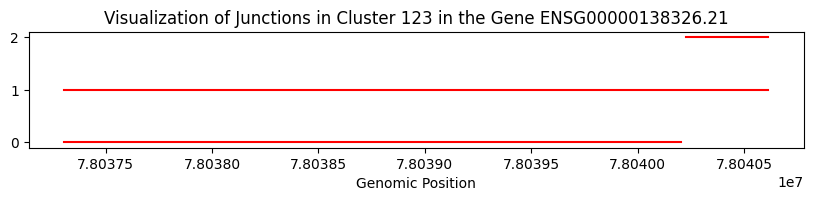

In [119]:
j = all_juncs_df.junction_id.sample(1).values[0]
visualize_junctions(all_juncs_df, j)